In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

In [6]:

def generate_dynamic_sbox(size, hybrid_keys):
    chaotic_sequence = hybrid_keys[:size]
    return np.argsort(chaotic_sequence)

In [7]:
cameraman = "C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/cameraman.png"
peppers = "C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/peppers.png"
camera = Image.open(cameraman).convert('RGB')  # Color image
cameraman_array = np.array(camera)
pepper = Image.open(peppers).convert('RGB')  # Color image
peppers_array = np.array(pepper)

In [8]:
import numpy as np
import random

def modify_single_pixel(image_array):

    # Get the dimensions of the image
    height, width, channels = image_array.shape

    # Randomly select a pixel (row, column)
    row = random.randint(0, height - 1)
    col = random.randint(0, width - 1)

    # Randomly assign a new value to the pixel
    random_value = np.random.randint(0, 256, size=channels, dtype=np.uint8)
    modified_image = image_array.copy()  # Create a copy to avoid altering the original image
    modified_image[row, col] = random_value

    return modified_image

In [9]:
def plot_images(original_image, encrypted_image, decrypted_image, shape):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(original_image.reshape(shape))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(encrypted_image.reshape(shape))
    axes[1].set_title("Encrypted Image")
    axes[1].axis('off')

    axes[2].imshow(decrypted_image.reshape(shape))
    axes[2].set_title("Decrypted Image")
    axes[2].axis('off')

    difference_image = np.abs(original_image - decrypted_image)
    axes[3].imshow(difference_image.reshape(shape))
    axes[3].set_title("Difference Image")
    axes[3].axis('off')

    plt.show()

(4000, 6000, 3)
Using block size: 16x16


C:\Users\20092\AppData\Local\Temp\ipykernel_48636\1785649586.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)


Encryption time: 3.0770 seconds
Decryption time: 16.7199 seconds


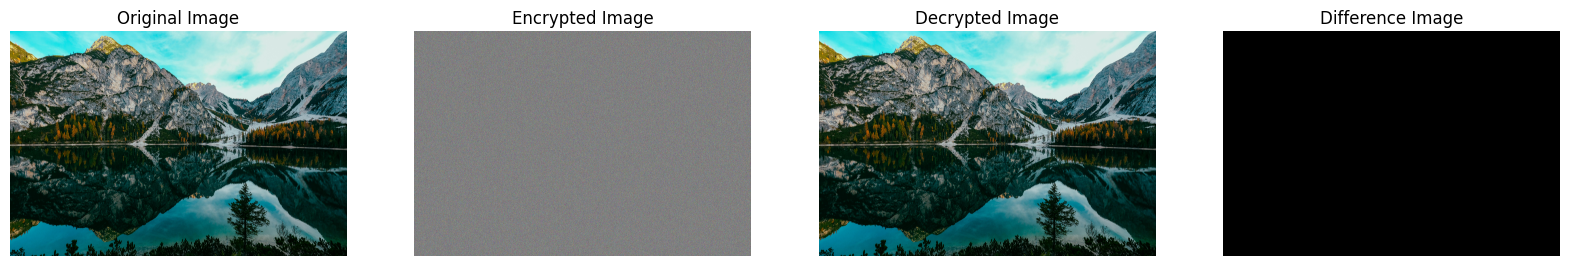

(512, 512, 3)
Using block size: 16x16
Encryption time: 0.0448 seconds
Decryption time: 0.1700 seconds


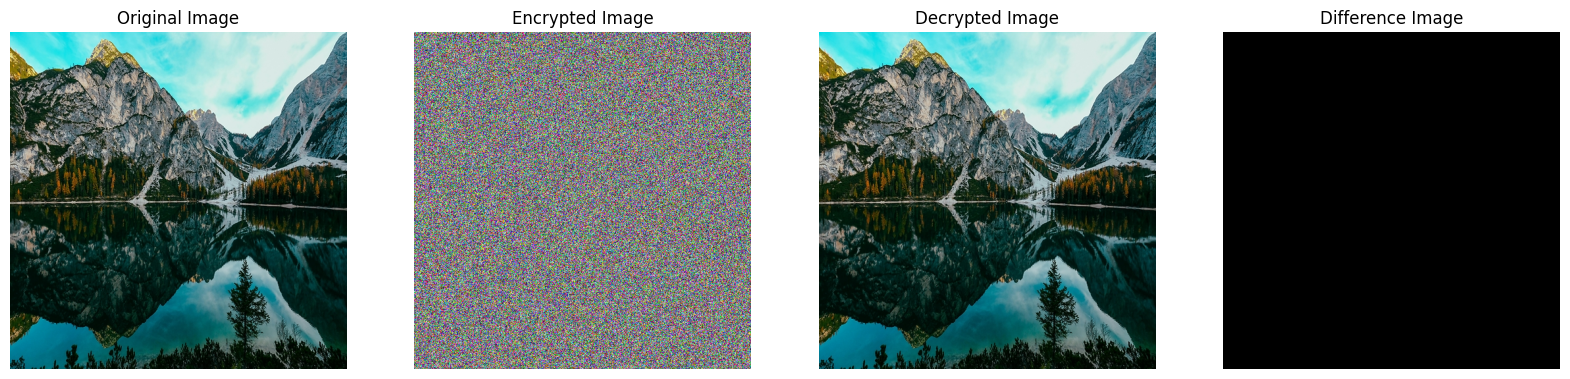

(2048, 2048, 3)
Using block size: 16x16
Encryption time: 0.4910 seconds
Decryption time: 3.0892 seconds


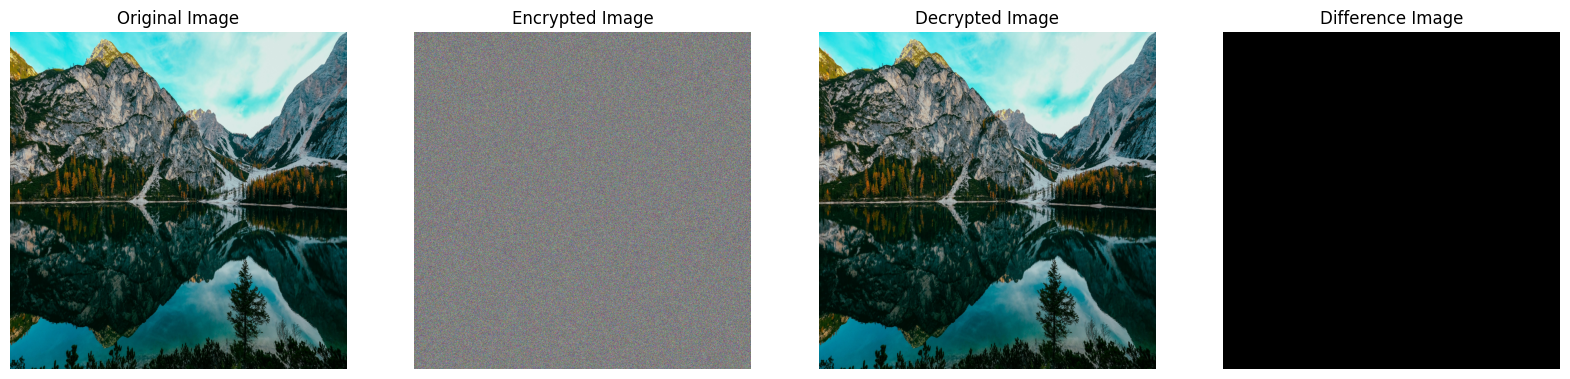

(256, 256, 3)
Using block size: 16x16
Encryption time: 0.0793 seconds
Decryption time: 0.1173 seconds


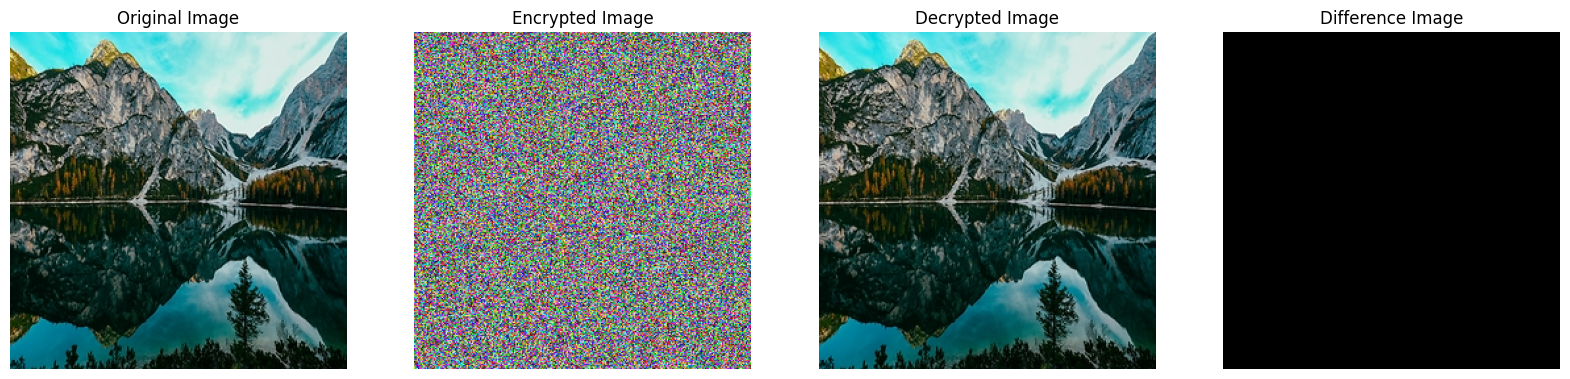

In [10]:


def compute_image_characteristics(image_array):
    avg_intensity = np.mean(image_array)
    variance = np.var(image_array)
    histogram, _ = np.histogram(image_array, bins=256, range=(0, 255))
    probabilities = histogram / np.sum(histogram)
    entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)
    return avg_intensity, variance, entropy

def determine_block_size(image_shape):
    print(image_shape)
    height, width = image_shape[:2]
    smaller_dim = min(height, width)
    if smaller_dim < 200:
        return 1
    if smaller_dim < 512:
        return 16
    elif smaller_dim <= 2048:
        return 16
    else:
        return 16

def divide_into_blocks(image_array, block_size):
    height, width, channels = image_array.shape
    padded_height = (height + block_size - 1) // block_size * block_size
    padded_width = (width + block_size - 1) // block_size * block_size

    padded_image = np.zeros((padded_height, padded_width, channels), dtype=image_array.dtype)
    padded_image[:height, :width, :] = image_array

    blocks = []
    for i in range(0, padded_height, block_size):
        for j in range(0, padded_width, block_size):
            blocks.append(padded_image[i:i + block_size, j:j + block_size])
    return blocks, (height, width), (padded_height, padded_width)

def merge_blocks(blocks, original_shape, padded_shape, block_size):
    padded_height, padded_width = padded_shape
    merged_image = np.zeros((padded_height, padded_width, blocks[0].shape[2]), dtype=blocks[0].dtype)

    block_index = 0
    for i in range(0, padded_height, block_size):
        for j in range(0, padded_width, block_size):
            merged_image[i:i + block_size, j:j + block_size] = blocks[block_index]
            block_index += 1

    return merged_image[:original_shape[0], :original_shape[1], :]

def generate_chen_keys(size, avg_intensity, variance):
    x, y, z = avg_intensity / 255.0, variance / 255.0, 0.1
    a, b, c = 35 + avg_intensity % 10, 3 + variance % 5, 28
    keys = []
    for _ in range(size):
        dx = a * (y - x)
        dy = x * (c - z) - y
        dz = x * y - b * z
        x += dx * 0.01
        y += dy * 0.01
        z += dz * 0.01
        keys.append(x)
    return np.abs(np.array(keys)) % 256

def generate_lorenz_keys(size, avg_intensity, entropy):
    x, y, z = avg_intensity / 255.0, 0.5, entropy / 10.0
    sigma, rho, beta = 10 + entropy % 5, 28 + avg_intensity % 10, 2.667
    keys = []
    for _ in range(size):
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        x += dx * 0.01
        y += dy * 0.01
        z += dz * 0.01
        keys.append(y)
    return np.abs(np.array(keys)) % 256

def generate_logistic_keys(size, variance, entropy):
    x = np.clip(variance / 255.0, 0.01, 0.99)
    r = np.clip(3.99 - (entropy % 0.1), 3.57, 4.0)
    keys = []
    for _ in range(size):
        x = r * x * (1 - x)
        keys.append(x)
    return (np.array(keys) * 255).astype(np.uint8)

def generate_hybrid_keys(avg_intensity, variance, entropy):
    key_size = 256  # Reduced key size
    chen_keys = generate_chen_keys(key_size, avg_intensity, variance)
    lorenz_keys = generate_lorenz_keys(key_size, avg_intensity, entropy)
    logistic_keys = generate_logistic_keys(key_size, variance, entropy)
    hybrid_keys = (lorenz_keys + logistic_keys + chen_keys) % 256
    return hybrid_keys



def encrypt_block_cbc(block, hybrid_keys, sbox, previous_block):
    flat_block = block.flatten()
    
    # Ensure the length of hybrid_keys matches the length of flat_block
    hybrid_keys_repeated = np.tile(hybrid_keys, (len(flat_block) // len(hybrid_keys)) + 1)[:len(flat_block)]
    
    xor_block = flat_block ^ previous_block.flatten()
    
    permutation_indices = np.argsort(hybrid_keys_repeated[:len(flat_block)])
    
    permuted_block = xor_block[permutation_indices]
    
    substituted_block = sbox[permuted_block]
    
    return substituted_block.reshape(block.shape), substituted_block.flatten(), permutation_indices

def decrypt_block_cbc(block, previous_block, permutation_indices, sbox_inv):
    flat_block = block.flatten()
    
    substituted_block = np.array([sbox_inv[pixel] for pixel in flat_block])
    
    reverse_indices = np.argsort(permutation_indices)
    
    permuted_block = substituted_block[reverse_indices]
    
    decrypted_block = permuted_block ^ previous_block.flatten()
    
    return decrypted_block.reshape(block.shape)

def main(image_array):
    block_size = determine_block_size(image_array.shape)
    print(f"Using block size: {block_size}x{block_size}")

    blocks, original_shape, padded_shape = divide_into_blocks(image_array, block_size)

    avg_intensity, variance, entropy = compute_image_characteristics(image_array)

    hybrid_keys = generate_hybrid_keys(avg_intensity, variance, entropy)

    sbox = generate_dynamic_sbox(256, hybrid_keys)
    sbox_inv = np.argsort(sbox)

    iv = np.random.randint(0, 256, (block_size, block_size, 3), dtype=np.uint8)

    encrypted_blocks = []
    permutation_indices_list = []
    previous_block = iv

    start_time = time.time()
    for block in blocks:
        encrypted_block, previous_block_flattened, permutation_indices = encrypt_block_cbc(
            block, hybrid_keys, sbox, previous_block
        )
        encrypted_blocks.append(encrypted_block)
        permutation_indices_list.append(permutation_indices)
        previous_block = previous_block_flattened.reshape(block.shape)
    encryption_time = time.time() - start_time

    encrypted_image = merge_blocks(encrypted_blocks, original_shape, padded_shape, block_size)

    extracted_blocks, _, _ = divide_into_blocks(encrypted_image, block_size)

    decrypted_blocks = []
    previous_block = iv

    start_time = time.time()
    for i, block in enumerate(extracted_blocks):
        decrypted_block = decrypt_block_cbc(block, previous_block, permutation_indices_list[i], sbox_inv)
        decrypted_blocks.append(decrypted_block)
        previous_block = block
    decryption_time = time.time() - start_time

    decrypted_image = merge_blocks(decrypted_blocks, original_shape, padded_shape, block_size)

    print(f"Encryption time: {encryption_time:.4f} seconds")
    print(f"Decryption time: {decryption_time:.4f} seconds")

    return encrypted_image, decrypted_image


if __name__ == "__main__":
    image = Image.open("C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/pexels-francesco-ungaro-1525041.jpg").convert('RGB')
    image_array = np.array(image)
    encrypted_image, decrypted_image = main(image_array)
    plot_images(image_array,encrypted_image,decrypted_image,image_array.shape)
    image = Image.open("C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/pexels-francesco-ungaro-1525041_resized_6745a7a466624.jpg").convert('RGB')
    image_array = np.array(image)
    encrypted_image, decrypted_image = main(image_array)
    plot_images(image_array,encrypted_image,decrypted_image,image_array.shape)
    image = Image.open("C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/pexels-francesco-ungaro-1525041_resized_6745a83f051f3.jpg").convert('RGB')
    image_array = np.array(image)
    encrypted_image, decrypted_image = main(image_array)
    plot_images(image_array,encrypted_image,decrypted_image,image_array.shape)
    image = Image.open("C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/pexels-francesco-ungaro-1525041_resized_6745a766ebcf7.jpg").convert('RGB')
    image_array = np.array(image)
    encrypted_image, decrypted_image = main(image_array)
    plot_images(image_array,encrypted_image,decrypted_image,image_array.shape)

In [11]:
encrypted_image,decrypted_image = main(cameraman_array)

(512, 512, 3)
Using block size: 16x16


C:\Users\20092\AppData\Local\Temp\ipykernel_48636\1785649586.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)


Encryption time: 0.0387 seconds
Decryption time: 0.1833 seconds


In [12]:
def calculate_npcr(original, modified):
    """Calculate NPCR (Number of Pixel Change Rate) between two images."""
    original = original.flatten()
    modified = modified.flatten()
    changed_pixels = np.sum(original != modified)
    total_pixels = original.size
    return (changed_pixels / total_pixels) * 100 

In [13]:
def calculate_entropy(image):
    """Calculate the entropy of an image."""
    histogram, _ = np.histogram(image.flatten(), bins=256, range=(0, 255))
    probabilities = histogram / np.sum(histogram)
    entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy


In [14]:
def calculate_uaci(original, modified):
    """Calculate UACI (Unified Average Changing Intensity) between two images."""
    original = original.flatten().astype(np.float32)
    modified = modified.flatten().astype(np.float32)
    uaci = np.sum(np.abs(original - modified)) / (255 * original.size)
    return uaci * 100  # Percentage

In [15]:
def calculate_correlation(original):
    """Calculate the horizontal, vertical, and diagonal correlation of an image."""
    height, width = original.shape[:2]

    # Horizontal correlation
    horizontal = np.corrcoef(original[:, :-1].flatten(), original[:, 1:].flatten())[0, 1]

    # Vertical correlation
    vertical = np.corrcoef(original[:-1, :].flatten(), original[1:, :].flatten())[0, 1]

    # Diagonal correlation
    diagonal = np.corrcoef(original[:-1, :-1].flatten(), original[1:, 1:].flatten())[0, 1]

    return horizontal, vertical, diagonal


In [16]:
def differential_analysis(original, encrypted_image, delta=1):
    """Perform differential analysis by changing one pixel and measuring NPCR and UACI."""
    modified_image = np.copy(original)
    modified_image[0, 0] = delta  # Change one pixel

    # Encrypt the modified image
    encrypted_modified = main(modified_image)[0]  # Assuming `encrypt_image` is defined

    # Calculate NPCR and UACI
    npcr = calculate_npcr(encrypted_image, encrypted_modified)
    uaci = calculate_uaci(encrypted_image, encrypted_modified)

    return npcr, uaci

In [17]:

def key_modification(hybrid_keys):
    """Modify the hybrid keys slightly and return the modified keys."""
    # Modify the first key slightly (e.g., add 1 to the first element)
    print(len(hybrid_keys))
    modified_keys = hybrid_keys.copy()
    modified_keys[10] = (modified_keys[110] + 112) % 256
    # modified_keys[129] = (modified_keys[0] + 12) % 256
    # modified_keys[229] = (modified_keys[10] + 12) % 256
    modified_keys[245] = (modified_keys[13] + 12) % 256
    # modified_keys[1] = (modified_keys[110] + 12) % 256
    return modified_keys

def determine_block_size1(image_shape):
    print(image_shape)
    
    
    
    height, width = image_shape[:2] 
        
    smaller_dim = min(height, width)    
    if smaller_dim <200:
        return 1
    if smaller_dim < 512:
        return 64  # Small images
    elif smaller_dim <= 2048:
        return 64  # Medium images
    else:
        return 64
    
def main1(image_array):
    # Determine block size dynamically
    block_size = determine_block_size1(image_array.shape)
    print(f"Using block sizer: {block_size}x{block_size}")

    # Divide image into blocks
    blocks, original_shape, padded_shape = divide_into_blocks(image_array, block_size)

    avg_intensity, variance, entropy = compute_image_characteristics(image_array)

    hybrid_keys = generate_hybrid_keys( avg_intensity, variance, entropy)

    # Perform key modification analysis
    modified_hybrid_keys = key_modification(hybrid_keys)

    # Generate S-Box with modified keys
    sbox = generate_dynamic_sbox(256, hybrid_keys)
    sbox_inv = np.argsort(sbox)
    modified_sbox = generate_dynamic_sbox(256,modified_hybrid_keys)
    modified_sbox_inv =np.argsort(sbox)
    # Encryption with original hybrid keys
    iv = np.random.randint(0, 256, (block_size, block_size, 3), dtype=np.uint8)

    encrypted_blocks = []
    permutation_indices_list = []
    previous_block = iv  # Start with IV
    for block in blocks:
        encrypted_block, previous_block_flattened, permutation_indices = encrypt_block_cbc(
            block, hybrid_keys, sbox, previous_block
        )
        encrypted_blocks.append(encrypted_block)
        permutation_indices_list.append(permutation_indices)
        previous_block = previous_block_flattened.reshape(block.shape)  # Update to the current encrypted block for next iteration

    encrypted_image = merge_blocks(encrypted_blocks, original_shape, padded_shape, block_size)
    # Now, encrypt using the modified keys
    encrypted_blocks_modified = []
    previous_block = iv
    for block in blocks:
        encrypted_block, previous_block_flattened, permutation_indices = encrypt_block_cbc(
            block, modified_hybrid_keys, modified_sbox, previous_block
        )
        encrypted_blocks_modified.append(encrypted_block)
        previous_block = previous_block_flattened.reshape(block.shape)

    encrypted_image_modified = merge_blocks(encrypted_blocks_modified, original_shape, padded_shape, block_size)

    # Decrypt the original encrypted image
    extracted_blocks, _, _ = divide_into_blocks(encrypted_image, block_size)
    decrypted_blocks = []
    previous_block = iv
    for i, block in enumerate(extracted_blocks):
        decrypted_block = decrypt_block_cbc(block, previous_block, permutation_indices_list[i], sbox_inv)
        decrypted_blocks.append(decrypted_block)
        previous_block = block

    decrypted_image = merge_blocks(decrypted_blocks, original_shape, padded_shape, block_size)

    # Decrypt the modified encrypted image
    extracted_blocks_modified, _, _ = divide_into_blocks(encrypted_image_modified, block_size)
    decrypted_blocks_modified = []
    previous_block = iv
    for i, block in enumerate(extracted_blocks_modified):
        decrypted_block = decrypt_block_cbc(block, previous_block, permutation_indices_list[i], modified_sbox_inv)
        decrypted_blocks_modified.append(decrypted_block)
        previous_block = block

    decrypted_image_modified = merge_blocks(decrypted_blocks_modified, original_shape, padded_shape, block_size)

    # Calculate NPCR and UACI for original vs modified encrypted images
    plot_images(image_array,encrypted_image,decrypted_image,image_array.shape)
    plot_images(image_array,encrypted_image_modified,decrypted_image_modified,image_array.shape)
    # Return the results
    return encrypted_image, encrypted_image_modified, decrypted_image, decrypted_image_modified

In [18]:
def key_modification_analysis(image):
    """Evaluate how changing the key affects the encryption."""
    
    encrypted_image, encrypted_image_modified, decrypted_image, decrypted_image_modified = main1(image)
    # Calculate NPCR and UACI for modified key
    npcr = calculate_npcr(encrypted_image, encrypted_image_modified)
    uaci = calculate_uaci(encrypted_image, encrypted_image_modified)
    npcr1 = calculate_npcr(decrypted_image, decrypted_image_modified)
    uaci1 = calculate_uaci(decrypted_image, decrypted_image_modified)
    
    print("key modification encypted npcr uaci",npcr,uaci)
    print("key modification decrypted npcr uaci",npcr1,uaci1)

In [19]:
import math

def calculate_psnr(original, modified):
    """Calculate PSNR (Peak Signal-to-Noise Ratio) between two images."""
    mse = np.mean((original - modified) ** 2)
    if mse == 0:
        return 100  # Infinite PSNR
    max_pixel = 255.0
    return 20 * math.log10(max_pixel / math.sqrt(mse))

In [20]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, modified):
    """Calculate SSIM (Structural Similarity Index) between two images."""
    return ssim(original, modified, multichannel=True,channel_axis=2)

In [21]:
from skimage.metrics import structural_similarity as ssim

def calculate_ms_ssim(original, modified):
    """Calculate MS-SSIM (Multi-Scale Structural Similarity Index) between two images."""
    return ssim(original, modified, multichannel=True, channel_axis =2,win_size=11, gaussian_weights=True, use_sample_covariance=False)

In [22]:
def average_effect(original, encrypted):
    """Calculate the average effect of encryption by measuring the pixel intensity differences."""
    diff = np.abs(original - encrypted)
    return np.mean(diff)


99.60581461588541
31.109643075980394
entropy: 6.049670834469638 7.999749342440867
corelation: (0.9829089761442564, 0.9898337151919586, 0.9730510546987491) (-0.0008939722801823882, -0.00012574892983599421, 0.0007008306642343402)
(512, 512, 3)
Using block size: 16x16


C:\Users\20092\AppData\Local\Temp\ipykernel_48636\3363542038.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)
C:\Users\20092\AppData\Local\Temp\ipykernel_48636\1785649586.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)


Encryption time: 0.0313 seconds
Decryption time: 0.1932 seconds
differential_analysis (99.61751302083334, 33.45103943270016)
(512, 512, 3)
Using block sizer: 64x64
256


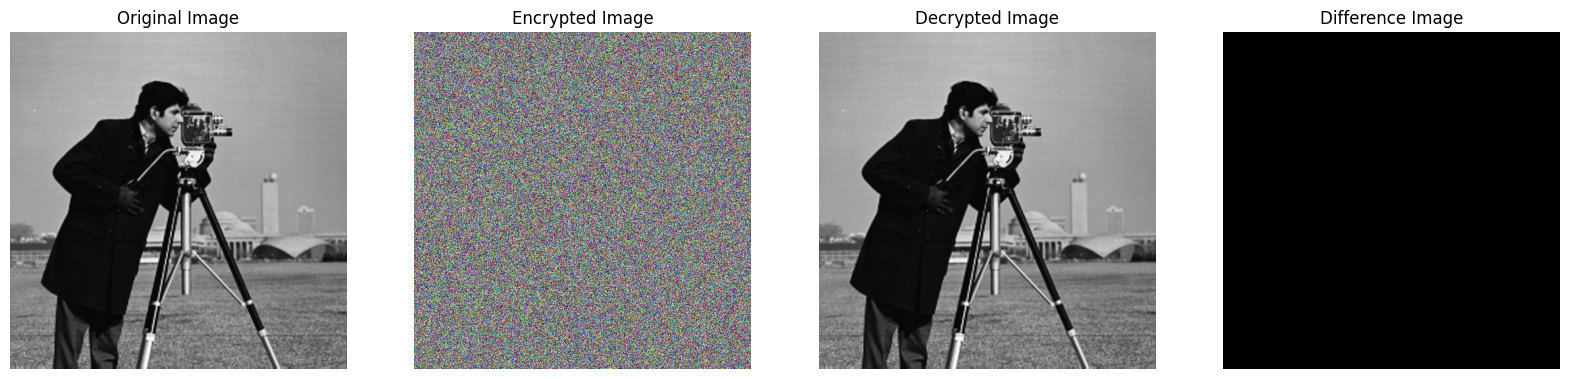

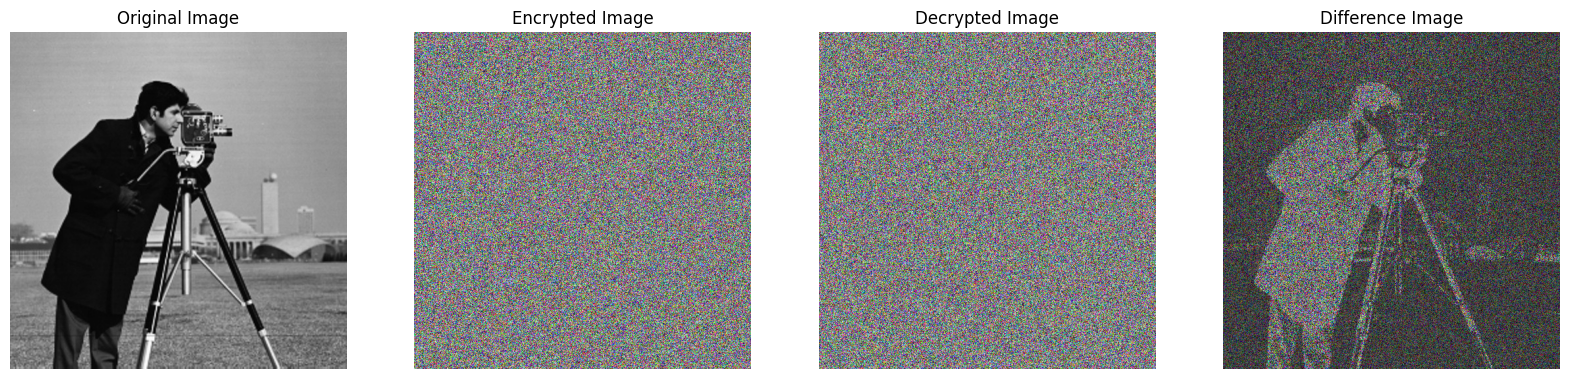

key modification encypted npcr uaci 99.60530598958334 33.444977803947104
key modification decrypted npcr uaci 99.36294555664062 30.93972598805147
psnr 8.406152253947608
calculate ssim 0.008408118355599228


c:\Users\20092\OneDrive\Documents\Bhumit\khetisahayaak\.venv\Lib\site-packages\skimage\metrics\_structural_similarity.py:142: UserWarning: Inputs have mismatched dtypes. Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[_at(ch)], im2[_at(ch)], **args)


ms_ssim 0.008873274204739419
average effect 79.32959874471028


In [23]:
# plot_images(cameraman_array,encrypted_image,decrypted_image,image_array.shape)
print(calculate_npcr(cameraman_array,encrypted_image))
print(calculate_uaci(cameraman_array,encrypted_image))
print("entropy:",calculate_entropy(cameraman_array),calculate_entropy(encrypted_image))
print("corelation:",calculate_correlation(cameraman_array),calculate_correlation(encrypted_image))
print("differential_analysis",differential_analysis(cameraman_array,encrypted_image))
key_modification_analysis(cameraman_array)
print("psnr",calculate_psnr(cameraman_array,encrypted_image))
print("calculate ssim",calculate_ssim(cameraman_array,encrypted_image))
print("ms_ssim",calculate_ms_ssim(cameraman_array,encrypted_image))
print("average effect", average_effect(cameraman_array,encrypted_image))

(384, 512, 3)
Using block size: 16x16
Encryption time: 0.0178 seconds
Decryption time: 0.1217 seconds
99.60700141059029
33.974109392020694


C:\Users\20092\AppData\Local\Temp\ipykernel_48636\1785649586.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)
C:\Users\20092\AppData\Local\Temp\ipykernel_48636\3363542038.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)


entropy: 7.378534223569768 7.999695601544351
corelation: (0.9935565009182993, 0.9892840566517063, 0.984250352531911) (-0.0004518140218399962, -0.0003568736579044635, 0.0015194670870760183)
(384, 512, 3)
Using block size: 16x16
Encryption time: 0.0156 seconds
Decryption time: 0.1368 seconds
differential_analysis (99.61208767361111, 33.41272956665305)
psnr 100
calculate ssim 0.008109834103095756
ms_ssim 0.008522879789422665
average effect 86.63398742675781
(384, 512, 3)
Using block sizer: 64x64
256


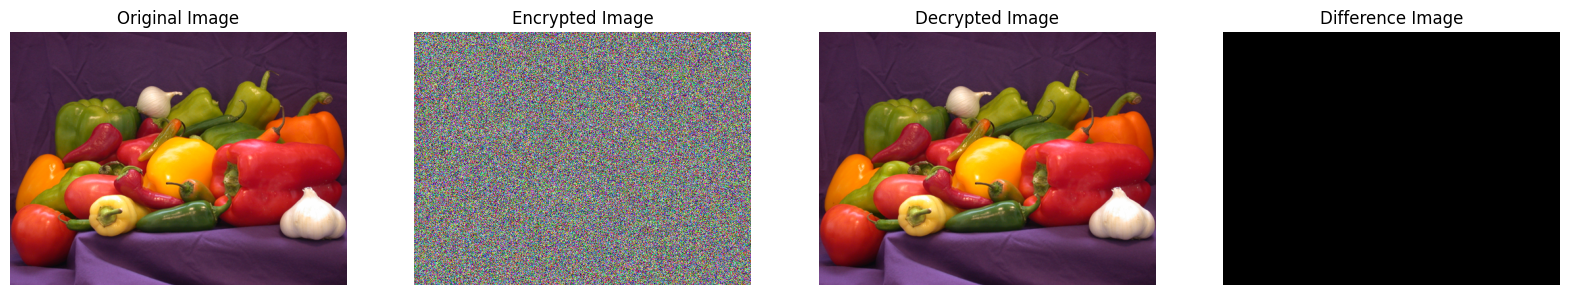

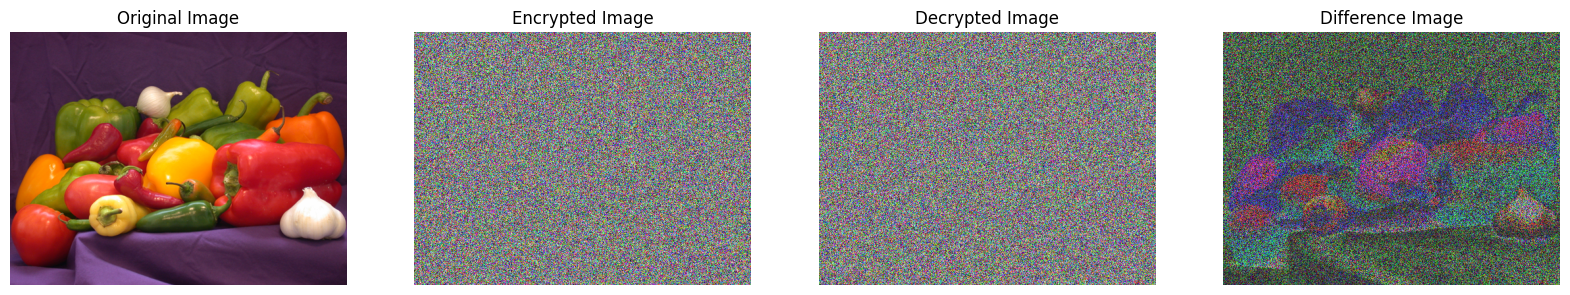

key modification encypted npcr uaci 99.60869683159721 33.44350245523557
key modification decrypted npcr uaci 99.46543375651041 33.87662600847631


In [24]:
encrypted_image,de = main(peppers_array)
print(calculate_npcr(peppers_array,encrypted_image))
print(calculate_uaci(peppers_array,encrypted_image))
print("entropy:",calculate_entropy(peppers_array),calculate_entropy(encrypted_image))
print("corelation:",calculate_correlation(peppers_array),calculate_correlation(encrypted_image))
print("differential_analysis",differential_analysis(peppers_array,encrypted_image))

print("psnr",calculate_psnr(peppers_array,de))
print("calculate ssim",calculate_ssim(peppers_array,encrypted_image))
print("ms_ssim",calculate_ms_ssim(peppers_array,encrypted_image))
print("average effect", average_effect(peppers_array,encrypted_image))
key_modification_analysis(peppers_array)

In [25]:
from scipy.stats import chisquare, kstest, normaltest
def nist_tests(image_array):
    # Flatten the image array to a 1D array
    flat_image = image_array.flatten()

    # Perform Chi-Square Test
    chi_square_stat, chi_square_p = chisquare(flat_image)

    # Perform Kolmogorov-Smirnov Test
    ks_stat, ks_p = kstest(flat_image, 'uniform', args=(0, 256))

    # Perform Normality Test
    normal_stat, normal_p = normaltest(flat_image)

    return {
        "Chi-Square Test": (chi_square_stat, chi_square_p),
        "Kolmogorov-Smirnov Test": (ks_stat, ks_p),
        "Normality Test": (normal_stat, normal_p)
    }

print(nist_tests(peppers_array))
print(nist_tests(encrypted_image))

{'Chi-Square Test': (26768851.95907251, 0.0), 'Kolmogorov-Smirnov Test': (0.36282687717013884, 0.0), 'Normality Test': (109618.18434345024, 0.0)}
{'Chi-Square Test': (25217010.958443217, 0.0), 'Kolmogorov-Smirnov Test': (0.004323323567708315, 5.296691639929594e-10), 'Normality Test': (527625.5634766998, 0.0)}


(384, 512, 3)
Using block size: 16x16
Encryption time: 0.0254 seconds
Decryption time: 0.1118 seconds
99.62734646267361
33.97123183040577


C:\Users\20092\AppData\Local\Temp\ipykernel_48636\1785649586.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)
C:\Users\20092\AppData\Local\Temp\ipykernel_48636\3363542038.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)


entropy: 7.378534223569768 7.999669320528687
corelation: (0.9935565009182993, 0.9892840566517063, 0.984250352531911) (-0.0014062235274065616, -0.0024682830389262046, -0.0016378016554809852)
(384, 512, 3)
Using block size: 16x16
Encryption time: 0.0190 seconds
Decryption time: 0.1215 seconds
differential_analysis (99.61157904730904, 33.47770607809096)
psnr 100
calculate ssim 0.0077846625282330965
ms_ssim 0.008312589986447455
average effect 86.62664964463976
(384, 512, 3)
Using block sizer: 64x64
256


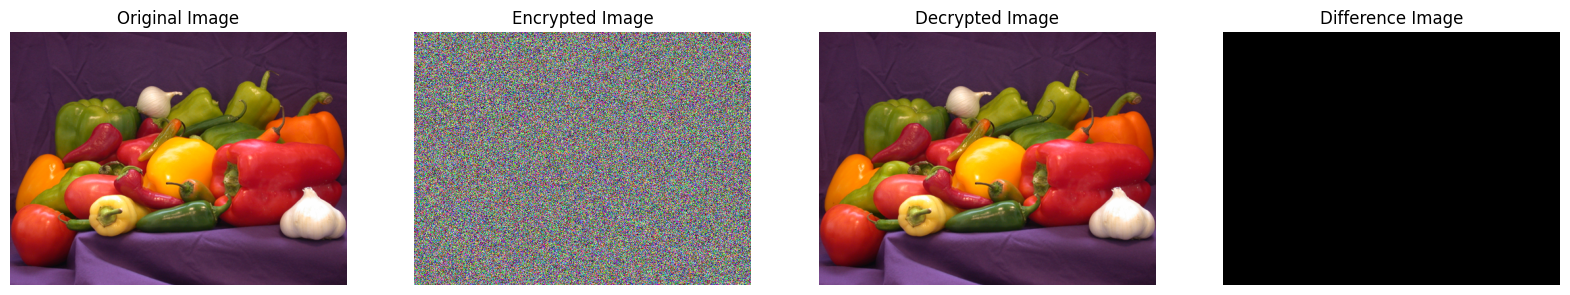

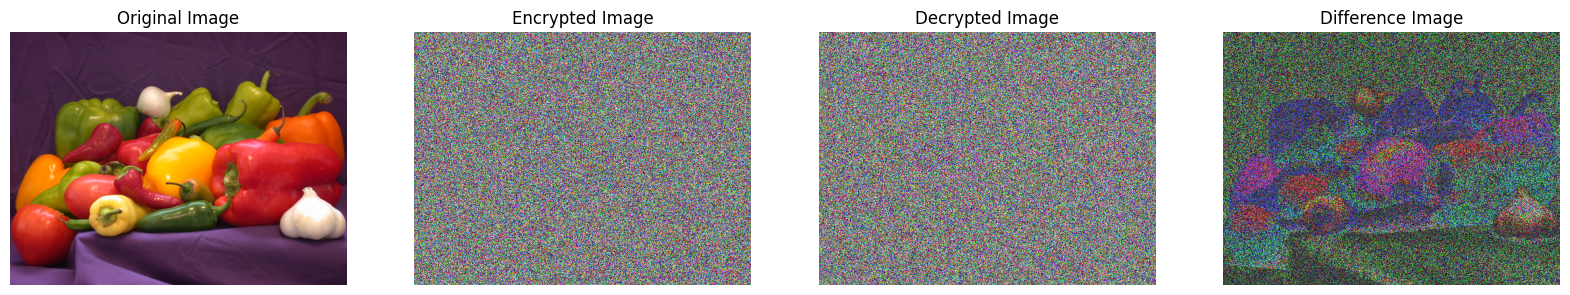

key modification encypted npcr uaci 99.59259033203125 33.45410049870643
key modification decrypted npcr uaci 99.48476155598959 33.82581656794662


In [26]:
image = Image.open("C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/peppers.png").convert('RGB')
image_array = np.array(image)
encrypted_image, decrypted_image = main(image_array)
print(calculate_npcr(image_array,encrypted_image))
print(calculate_uaci(image_array,encrypted_image))
print("entropy:",calculate_entropy(image_array),calculate_entropy(encrypted_image))
print("corelation:",calculate_correlation(image_array),calculate_correlation(encrypted_image))
print("differential_analysis",differential_analysis(image_array,encrypted_image))

print("psnr",calculate_psnr(image_array,decrypted_image))
print("calculate ssim",calculate_ssim(image_array,encrypted_image))
print("ms_ssim",calculate_ms_ssim(image_array,encrypted_image))
print("average effect", average_effect(image_array,encrypted_image))
key_modification_analysis(image_array)

In [ ]:
cal

(512, 512, 3)
Using block size: 16x16


C:\Users\20092\AppData\Local\Temp\ipykernel_48636\1785649586.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in probabilities if p > 0)


Encryption time: 0.0316 seconds
Decryption time: 0.1774 seconds


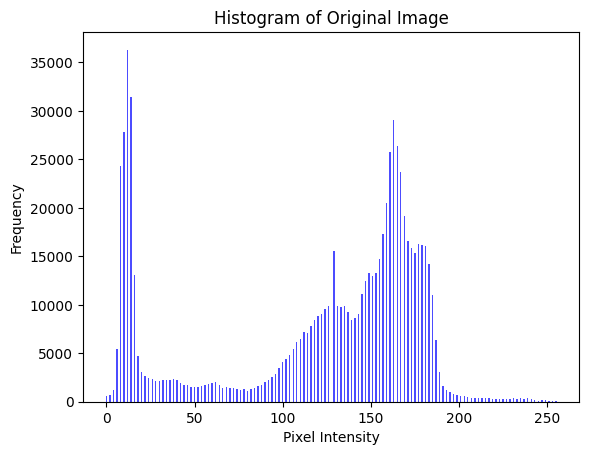

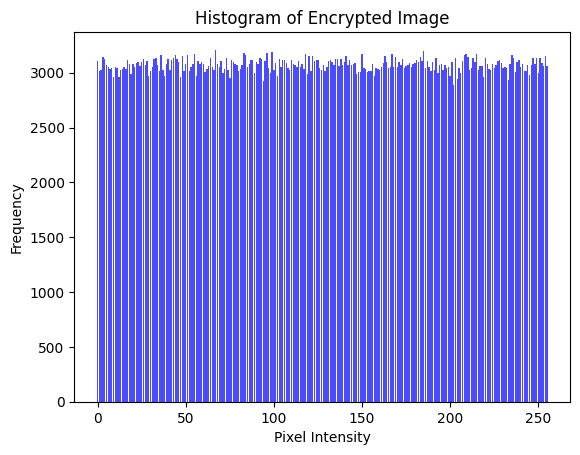

In [27]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def plot_histogram(image, title):
    histogram = np.histogram(image.flatten(), bins=256, range=(0, 256))[0]
    plt.bar(range(256), histogram, color="blue", alpha=0.7)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

def plot_histogram_uniformity(image, title):
    histogram, _ = np.histogram(image.flatten(), bins=256, range=(0, 256))
    plt.bar(range(256), histogram, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

def main1(image_path):
    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image)
    
    # Encrypt the image
    encrypted_image, decrypted_image = main(image_array)
    
    # Plot histogram of the original image
    plot_histogram_uniformity(image_array, "Histogram of Original Image")
    
    # Plot histogram of the encrypted image
    plot_histogram_uniformity(encrypted_image, "Histogram of Encrypted Image")

if __name__ == "__main__":
    image_path = "C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/cameraman.png"
    main1(image_path)

In [28]:
%pip uninstall crypto


%pip uninstall cryptography

^C
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip show pycryptodome


In [ ]:
# %pip show pycryptodome
%pip install cryptography


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.padding import PKCS7
from cryptography.hazmat.backends import default_backend
import numpy as np
import os
import math
from PIL import Image
import time

# Helper functions for padding and unpadding
def pad(data, block_size):
    padder = PKCS7(block_size * 8).padder()
    return padder.update(data) + padder.finalize()

def unpad(data, block_size):
    unpadder = PKCS7(block_size * 8).unpadder()
    return unpadder.update(data) + unpadder.finalize()

# AES encryption function
def encrypt_aes(image_array, key):
    iv = os.urandom(16)  # Generate a random initialization vector
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_data = pad(image_array.tobytes(), algorithms.AES.block_size)
    encrypted_data = encryptor.update(padded_data) + encryptor.finalize()
    return iv + encrypted_data

# AES decryption function
def decrypt_aes(encrypted_data, key, image_shape):
    iv = encrypted_data[:16]
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    decrypted_data = decryptor.update(encrypted_data[16:]) + decryptor.finalize()
    return np.frombuffer(unpad(decrypted_data, algorithms.AES.block_size), dtype=np.uint8).reshape(image_shape)

# Function to calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(original, modified):
    mse = np.mean((original - modified) ** 2)
    if mse == 0:
        return 100  # Infinite PSNR
    max_pixel = 255.0
    return 20 * math.log10(max_pixel / math.sqrt(mse))

# Main script
if __name__ == "__main__":
    # Path to the image file
    image_path = "C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/pexels-francesco-ungaro-1525041.jpg"

    # Load and process the image
    image = Image.open(image_path).convert('RGB')  # Convert to RGB format
    image_array = np.array(image)  # Convert image to NumPy array

    # Generate a random 256-bit AES key
    key = os.urandom(32)

    # AES Encryption
    start_time = time.time()
    encrypted_data = encrypt_aes(image_array, key)
    encryption_time = time.time() - start_time

    # AES Decryption
    start_time = time.time()
    decrypted_image_array = decrypt_aes(encrypted_data, key, image_array.shape)
    decryption_time = time.time() - start_time

    # Calculate PSNR
    psnr = calculate_psnr(image_array, decrypted_image_array)

    # Save decrypted image for comparison
    decrypted_image = Image.fromarray(decrypted_image_array)
    decrypted_image.save("decrypted_image.jpg")
    print(calculate_ssim(image_array,encrypted_data))
    # Print results
    print(f"AES Encryption Time: {encryption_time:.4f} seconds")
    print(f"AES Decryption Time: {decryption_time:.4f} seconds")
    print(f"AES PSNR: {psnr:.4f}")

    # Display original and decrypted images for verification
    image.show(title="Original Image")
    decrypted_image.show(title="Decrypted Image")


AttributeError: 'bytes' object has no attribute 'shape'

In [35]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.padding import PKCS7
import numpy as np
import os
import math
from PIL import Image
import time

# Helper functions for padding and unpadding
def pad(data, block_size):
    padder = PKCS7(block_size * 8).padder()
    return padder.update(data) + padder.finalize()

def unpad(data, block_size):
    unpadder = PKCS7(block_size * 8).unpadder()
    return unpadder.update(data) + unpadder.finalize()

# Blowfish encryption function
def encrypt_blowfish(image_array, key):
    iv = os.urandom(8)  # Blowfish IV size is 8 bytes
    cipher = Cipher(algorithms.Blowfish(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_data = pad(image_array.tobytes(), algorithms.Blowfish.block_size)
    encrypted_data = encryptor.update(padded_data) + encryptor.finalize()
    return iv + encrypted_data

# Blowfish decryption function
def decrypt_blowfish(encrypted_data, key, image_shape):
    iv = encrypted_data[:8]
    cipher = Cipher(algorithms.Blowfish(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    decrypted_data = decryptor.update(encrypted_data[8:]) + decryptor.finalize()
    return np.frombuffer(unpad(decrypted_data, algorithms.Blowfish.block_size), dtype=np.uint8).reshape(image_shape)

# ChaCha20 encryption function
def encrypt_chacha20(image_array, key):
    nonce = os.urandom(16)  # ChaCha20 nonce size is 16 bytes
    cipher = Cipher(algorithms.ChaCha20(key, nonce), mode=None, backend=default_backend())
    encryptor = cipher.encryptor()
    encrypted_data = encryptor.update(image_array.tobytes()) + encryptor.finalize()
    return nonce + encrypted_data

# ChaCha20 decryption function
def decrypt_chacha20(encrypted_data, key, image_shape):
    nonce = encrypted_data[:16]
    cipher = Cipher(algorithms.ChaCha20(key, nonce), mode=None, backend=default_backend())
    decryptor = cipher.decryptor()
    decrypted_data = decryptor.update(encrypted_data[16:]) + decryptor.finalize()
    return np.frombuffer(decrypted_data, dtype=np.uint8).reshape(image_shape)

# Function to calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(original, modified):
    mse = np.mean((original - modified) ** 2)
    if mse == 0:
        return 100  # Infinite PSNR
    max_pixel = 255.0
    return 20 * math.log10(max_pixel / math.sqrt(mse))

# Main script
if __name__ == "__main__":
    # Path to the image file
    image_path = "C:/Users/20092/OneDrive/Documents/Bhumit/cyptography/pexels-francesco-ungaro-1525041.jpg"

    # Load and process the image
    image = Image.open(image_path).convert('RGB')  # Convert to RGB format
    image_array = np.array(image)  # Convert image to NumPy array

    # Generate random keys
    key_blowfish = os.urandom(16)  # Blowfish key size (up to 56 bytes)
    key_chacha20 = os.urandom(32)  # ChaCha20 key size (256 bits)

    # Blowfish Encryption and Decryption
    start_time = time.time()
    encrypted_blowfish = encrypt_blowfish(image_array, key_blowfish)
    encryption_time_blowfish = time.time() - start_time

    start_time = time.time()
    decrypted_blowfish = decrypt_blowfish(encrypted_blowfish, key_blowfish, image_array.shape)
    decryption_time_blowfish = time.time() - start_time

    psnr_blowfish = calculate_psnr(image_array, decrypted_blowfish)

    # Save decrypted Blowfish image
    decrypted_image_blowfish = Image.fromarray(decrypted_blowfish)
    # decrypted_image_blowfish.save("decrypted_blowfish_image.jpg")

    # ChaCha20 Encryption and Decryption
    start_time = time.time()
    encrypted_chacha20 = encrypt_chacha20(image_array, key_chacha20)
    encryption_time_chacha20 = time.time() - start_time

    start_time = time.time()
    decrypted_chacha20 = decrypt_chacha20(encrypted_chacha20, key_chacha20, image_array.shape)
    decryption_time_chacha20 = time.time() - start_time

    psnr_chacha20 = calculate_psnr(image_array, decrypted_chacha20)

    # Save decrypted ChaCha20 image
    decrypted_image_chacha20 = Image.fromarray(decrypted_chacha20)
    # decrypted_image_chacha20.save("decrypted_chacha20_image.jpg")

    # Print results
    # print(calculate_ssim(image_array,encrypted_blowfish))
    print(f"Blowfish Encryption Time: {encryption_time_blowfish:.4f} seconds")
    print(f"Blowfish Decryption Time: {decryption_time_blowfish:.4f} seconds")
    print(f"Blowfish PSNR: {psnr_blowfish:.4f}")

    # print(calculate_ssim(image_array,encrypted_chacha20))
    print(f"ChaCha20 Encryption Time: {encryption_time_chacha20:.4f} seconds")
    print(f"ChaCha20 Decryption Time: {decryption_time_chacha20:.4f} seconds")
    print(f"ChaCha20 PSNR: {psnr_chacha20:.4f}")

    # Display decrypted images
    decrypted_image_blowfish.show(title="Decrypted Blowfish Image")
    decrypted_image_chacha20.show(title="Decrypted ChaCha20 Image")


C:\Users\20092\AppData\Local\Temp\ipykernel_48636\8308010.py:22: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  cipher = Cipher(algorithms.Blowfish(key), modes.CBC(iv), backend=default_backend())
C:\Users\20092\AppData\Local\Temp\ipykernel_48636\8308010.py:24: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  padded_data = pad(image_array.tobytes(), algorithms.Blowfish.block_size)
C:\Users\20092\AppData\Local\Temp\ipykernel_48636\8308010.py:31: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  cipher = Cipher(algorithms.Blowfish(key), modes.CBC(iv), backend=default_backend())
C:\Users\20092\AppData\Local\Temp\ipykernel_48636\8308010.py:34: C

Blowfish Encryption Time: 0.7946 seconds
Blowfish Decryption Time: 0.7325 seconds
Blowfish PSNR: 100.0000
ChaCha20 Encryption Time: 0.0851 seconds
ChaCha20 Decryption Time: 0.0616 seconds
ChaCha20 PSNR: 100.0000
